In [1]:
using Pkg
Pkg.activate("/kuacc/users/ckorkmaz16/HiSD.jl/")

  Activating environment at `~/HiSD.jl/Project.toml`


In [2]:
run(`nvidia-smi`)

Mon Nov  8 15:46:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   38C    P0    26W /  70W |      0MiB / 15109MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Process(`nvidia-smi`, ProcessExited(0))

In [17]:
include("data.jl")
using .Data
include("transformations.jl")
using .Transformations
include("utils.jl")
using .Utils

In [80]:
using Images, Interpolations
using Images.FileIO
using Statistics
using Dates
using TensorBoardLogger, Logging, Random
using FileIO
using CUDA: CUDA, CuArray
using Knet

In [5]:
DATA_ROOT = "/kuacc/users/ckorkmaz16/HiSD_out"
CONFIG_FILE = "/kuacc/users/ckorkmaz16/HiSD.jl/configs/celeba-hq.yaml"

config = Utils.load_config(CONFIG_FILE)
println("Loaded config")

Loaded config


In [128]:
datasets = Utils.get_train_datasets(config, DATA_ROOT)
println("Loaded $(sum(length.(datasets))) datasets")
(x,y),i = iterate(datasets[1][1], 0)
size(x), size(y), i, typeof(x), typeof(y)

Loaded 7 datasets


((128, 128, 3, 8), (2, 8), 8, KnetArray{Float32, 4}, Knet.KnetArrays.KnetMatrix{Float32})

In [20]:
function show_image(x, i)
    xs = x[:,:,:,i:i]
    xs = permutedims(xs, [4, 3, 1, 2])
    image = reshape(xs, size(xs)[2:end]...)
    image = convert(Array, image)    
    image = image .* 0.5 .+ 0.5
    image = clamp.(image, 0.0, 1.0)
    image = image .|> N0f8 |> colorview(RGB)
    image 
end

show_image (generic function with 1 method)

In [133]:
module Network

using Knet
include("primitives.jl")
using .Primitives

export DownBlock
struct DownBlock; conv1; conv2; sc; activ; end
DownBlock(in_ch::Int,out_ch::Int) = 
    DownBlock(Conv(in_ch, in_ch, 3, 1), Conv(in_ch, out_ch, 3, 1), Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::DownBlock)(x)
    residual = avg_pool2d(d.sc(x), 2)
    out = d.conv2(d.activ(avg_pool2d(d.conv1(d.activ(x)), 2)))
    return (residual + out) / sqrt(2)  
end

export DownBlockIN
struct DownBlockIN; conv1; conv2; in1; in2; sc; activ; end
DownBlockIN(in_ch::Int,out_ch::Int) = 
    DownBlockIN(Conv(in_ch, in_ch, 3, 1), Conv(in_ch, out_ch, 3, 1), 
                InstanceNorm2d(in_ch), InstanceNorm2d(in_ch),
                Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::DownBlockIN)(x)
    residual = avg_pool2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.in2(avg_pool2d(d.conv1(d.activ(d.in1(x))), 2))))
    return (residual + out) / sqrt(2)  
end

export UpBlock
struct UpBlock; conv1; conv2; sc; activ; end
UpBlock(in_ch::Int,out_ch::Int) = 
    UpBlock(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::UpBlock)(x)
    residual = upsample2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.conv1(upsample2d(d.activ(x), 2))))
    return (residual + out) / sqrt(2)  
end

export UpBlockIN
struct UpBlockIN; conv1; conv2; in1; in2; sc; activ; end
UpBlockIN(in_ch::Int,out_ch::Int) = 
    UpBlockIN(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), 
              InstanceNorm2d(in_ch), InstanceNorm2d(out_ch),
              Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::UpBlockIN)(x)
    residual = upsample2d(d.sc(x), 2)
    out = d.conv2(d.activ(d.in2(d.conv1(upsample2d(d.activ(d.in1(x)), 2)))))
    return (residual + out) / sqrt(2)  
end


export MiddleBlock, num_adain_params, assign_adain_params
struct MiddleBlock; conv1; conv2; adain1; adain2; sc; activ; end
MiddleBlock(in_ch::Int,out_ch::Int) = 
    MiddleBlock(Conv(in_ch, out_ch, 3, 1), Conv(out_ch, out_ch, 3, 1), 
                AdaptiveInstanceNorm2d(in_ch), AdaptiveInstanceNorm2d(out_ch),
                Conv(in_ch, out_ch, 1, 0, bias=false), LeakyRelu(0.2))
function (d::MiddleBlock)(x)
    residual = d.sc(x)
    out = d.conv2(d.activ(d.adain2(d.conv1(d.activ(d.adain1(x))))))
    return (residual + out) / sqrt(2)  
end
Primitives.num_adain_params(d::MiddleBlock) = num_adain_params(d.adain1) + num_adain_params(d.adain2)
function Primitives.assign_adain_params(d::MiddleBlock, params)
    params = assign_adain_params(d.adain1, params)
    params = assign_adain_params(d.adain2, params)
    return params
end

export LinearBlock
struct LinearBlock; l; end
LinearBlock(in_dim::Int, out_dim::Int) = LinearBlock(Linear(in_dim, out_dim))
(l::LinearBlock)(x) = l(relu.(x))

export Extractors
struct Extractors; num_tags; model; end
function Extractors(config) 
    num_tags = length(config["tags"])
    channels = config["extractors"]["channels"]
    Extractors(num_tags, Chain(
            Conv(config["input_dim"], channels[1], 1, 0), 
            [DownBlock(channels[i], channels[i + 1]) for i in 1:(length(channels)-1)]...,
            AdaptiveAvgPool2d(1),
            Conv(channels[end],  config["style_dim"] * num_tags, 1, 0),
        )
    )
end
function (e::Extractors)(x, i)
    sty = e.model(x)
    sz = size(sty)
    sty = reshape(sty, (prod(sz) ÷ (e.num_tags * sz[end]), e.num_tags, sz[end]))
    return sty[:, i, :]
end

export Mapper
struct Mapper; pre_model; post_models; end
function Mapper(config, num_attributes::Int64)
    channels = config["mappers"]["pre_channels"]
    pre_model = Chain(
        Linear(config["noise_dim"], channels[1]),
        [LinearBlock(channels[i], channels[i+1]) for i in 1:(length(channels)-1)]...
    )
    channels = config["mappers"]["post_channels"]
    post_models = [
        Chain(
            [LinearBlock(channels[i], channels[i+1]) for i in 1:(length(channels)-1)]...,
            Linear(channels[end], config["style_dim"])
        ) for i in 1:num_attributes
    ]
    Mapper(pre_model, post_models)
end
(m::Mapper)(z, j) = post_models[j](pre_model(z))

export Translator
struct Translator; model; style_to_params; features; masks; end
function Translator(config)
    channels = config["translators"]["channels"]
    model = Chain(
        Conv(config["encoder"]["channels"][end], channels[1], 1, 0),
        [MiddleBlock(channels[i], channels[i+1]) for i in 1:(length(channels)-1)]...
    )
    style_to_params = Linear(config["style_dim"], num_adain_params(model))
    features = Chain(
        Conv(channels[end], config["decoder"]["channels"][1], 1, 0)
    )
    masks = Chain(
        Conv(channels[end], config["decoder"]["channels"][1], 1, 0),
        Sigmoid()
    )
    Translator(model, style_to_params, features, masks)
end
function (t::Translator)(e, s)
    p = t.style_to_params(s)
    assign_adain_params(t.model, p)
    
    mid = t.model(e)
    f = t.features(mid)
    m = t.masks(mid)
    
    return f * m + e * (1-m)
end

export Generator, encode, decode, extract, map, translate
struct Generator; tags; style_dim; noise_dim; encoder; decoder; extractors; translators; mappers; end
function Generator(config)
    tags = config["tags"]
    style_dim = config["style_dim"]
    noise_dim = config["noise_dim"]
    
    channels = config["encoder"]["channels"]
    encoder = Chain(
        Conv(config["input_dim"], channels[1], 1, 0),
        [DownBlockIN(channels[i], channels[i+1]) for i in 1:(length(channels)-1)]...
    )
    
    channels = config["decoder"]["channels"]
    decoder = Chain(
        [UpBlockIN(channels[i], channels[i+1]) for i in 1:(length(channels)-1)]...,
        Conv(channels[end], config["input_dim"], 1, 0)
    )
    
    extractors = Extractors(config)
    translators = [Translator(config) for i in 1:length(tags)]
    mappers = [Mapper(config, length(tags[i]["attributes"])) for i in 1:length(tags)]
    
    Generator(tags, style_dim, noise_dim, encoder, decoder, extractors, translators, mappers)
end
encode(g::Generator, x) = g.encoder(x)
decode(g::Generator, e) = g.decoder(e)
extract(g::Generator, x, i) = g.extractors(x, i)
map(g::Generator, z, i, j) = g.mappers[i](z, j)
translate(g::Generator, e, s, i) = g.translators[i](e, s)

#TODO: Discriminator

export Discriminator
struct Discriminator; tags; conv; fcs; end
function Discriminator(config)
    tags = config["tags"]
    channels = config["discriminators"]["channels"]
    conv = Chain(
        Conv(config["input_dim"], channels[1], 1, 0),
        [DownBlock(channels[i], channels[i+1]) for i in 1:(length(channels)-1)]...,
        AdaptiveAvgPool2d(1)
    )
    
    fcs = [
        Chain(
            Conv(channels[end] + 
                 # ALI part, not shown in original submission
                 # config["style_dim"] + 
                 # Tag-irrelevant part. Sec.3.4
                 tags[i]["tag_irrelevant_conditions_dim"],
                 # One for translated, one for cycle. Eq.4
                 length(tags[i]["attributes"]) * 2, 1, 0)
        ) for i in 1:length(tags)
    ]
    
    Discriminator(tags, conv, fcs)
end
function (d::Discriminator)(x, #=s,=# y, i)
    f = d.conv(x)
    # TODO: Change tile_like's, what we need is simpler
    # Original implementation does this after AdaptiveAvgPool2d like us, which is not necessary
    # Everything is already 1x1xCxB
    fsy = cat(f, #= tile_like(s, f), =# tile_like(y, f), dims=3)
    out = self.fcs[i](fsy)
    so = size(out)
    return reshape(out, (prod(so) / (2*so[end]), 2, so[end]))
end

export dis_loss_real, dis_loss_fake_trg, dis_loss_fake_cyc, gen_loss_real, gen_loss_fake_trg, gen_loss_fake_cyc
function dis_loss_real(d::Discriminator, x, y, i, j)
    out = d(x, y, i)[j, :, :]
    loss = mean(relu.(1 .- out[1, :])) + mean(relu.(1 .- out[2, :]))
    # R1 regularization (TODO: better implementations?, this requires running the model 3 times)
    # loss += grad2(out[:, 0], x) + grad2(out[:, 1], x)
    x = Param(x)
    gout1 = @diff sum(d(x, y, i)[j, 1, :])
    gout1_grad = grad(gout1, x)
    loss += mean(sum(abs2.(gout1_grad),dims=2))
    gout2 = @diff sum(d(x, y, i)[j, 2, :])
    gout2_grad = grad(gout2, x)
    loss += mean(sum(abs2.(gout2_grad),dims=2))
    return loss
end
function dis_loss_fake_trg(d::Discriminator, x, y, i, j)
    out = d(x, y, i)[j, :, :]
    loss = mean(relu.(1 .+ out[1, :]))
    return loss
end
function dis_loss_fake_cyc(d::Discriminator, x, y, i, j)
    out = d(x, y, i)[j, :, :]
    loss = mean(relu.(1 .+ out[2, :]))
    return loss
end
function gen_loss_real(d::Discriminator, x, y, i, j)
    out = d(x, y, i)[j, :, :]
    loss = mean(out[1, :]) + mean(out[2, :])
    return loss
end
function gen_loss_fake_trg(d::Discriminator, x, y, i, j)
    out = d(x, y, i)[j, :, :]
    loss = -mean(out[1, :])
    return loss
end
function gen_loss_fake_cyc(d::Discriminator, x, y, i, j)
    out = d(x, y, i)[j, :, :]
    loss = -mean(out[2, :])
    return loss
end

end

using .Network

In [134]:
c = Network.Discriminator(config)

Main.Network.Discriminator(Dict{Any, Any}[Dict("name" => "Bangs", "attributes" => Dict{Any, Any}[Dict("name" => "with", "filename" => "datasets/Bangs_with.txt"), Dict("name" => "without", "filename" => "datasets/Bangs_without.txt")], "tag_irrelevant_conditions_dim" => 2), Dict("name" => "Eyeglasses", "attributes" => Dict{Any, Any}[Dict("name" => "with", "filename" => "datasets/Eyeglasses_with.txt"), Dict("name" => "without", "filename" => "datasets/Eyeglasses_without.txt")], "tag_irrelevant_conditions_dim" => 2), Dict("name" => "HairColor", "attributes" => Dict{Any, Any}[Dict("name" => "black", "filename" => "datasets/HairColor_black.txt"), Dict("name" => "blond", "filename" => "datasets/HairColor_blond.txt"), Dict("name" => "brown", "filename" => "datasets/HairColor_brown.txt")], "tag_irrelevant_conditions_dim" => 2)], Main.Network.Primitives.Chain((Main.Network.Primitives.Conv(P(KnetArray{Float32, 4}(1,1,3,64)), P(KnetArray{Float32, 4}(1,1,64,1)), 0, 1), Main.Network.DownBlock(Main.N

In [118]:
GC.gc(true)
l(x,y) = mean(abs2.(x-Network.decode(c, Network.encode(c, x))))
progress!(adam(l, Iterators.take(datasets[1][1], 1000)))

┣████████████████████┫ [100.00%, 1000/1000, 02:18/02:18, 7.25i/s] 


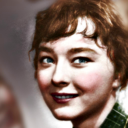

In [119]:
show_image(x, 1)

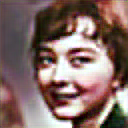

In [122]:
show_image(Network.decode(c, Network.encode(c, x)), 1)

In [127]:
GC.gc(true)

In [126]:
run(`nvidia-smi`)

Process(`nvidia-smi`, ProcessExited(0))